In [1]:
from netCDF4 import Dataset
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np


In [22]:
from datetime import datetime, timedelta

In [30]:
(datetime.today() - datetime(1992, 10, 5)).days

9661

ValueError: day is out of range for month

In [19]:
base_url = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/oscar_vel'9660


number of days since October 5, 1992



d = datetime.today() - timedelta(days=datetime(5, 10, 1992))

files = [f'{base_url}.{year}.nc' for year in range(1948, 2019)]
print(files)

SyntaxError: invalid syntax (<ipython-input-19-45eae94f8605>, line 1)

In [16]:
xr.open_dataset(')

OSError: [Errno -70] NetCDF: DAP server error: b'https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/oscar_vel9660.nc.gz.html'

In [13]:
from datetime import datetime
from siphon.catalog import TDSCatalog # https://unidata.github.io/siphon/
import metpy
import xarray as xr

# get the latest GFS forecast
nowdate = datetime(2018,10,11) # datetime.utcnow()
time = '0000'
catalog = TDSCatalog('https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/oscar_vel9578.nc.gz.html')


info = """
Catalog information
-------------------

Base THREDDS URL: {}
Catalog name: {}
Catalog URL: {}
Metadata: {}
""".format(catalog.base_tds_url,
           catalog.catalog_name,
           catalog.catalog_url,
           catalog.metadata)

print(info)

/Users/pmiron/miniconda3/lib/python3.6/site-packages/siphon/catalog.py:268: UserWarning: URL https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/oscar_vel9578.nc.gz.html returned HTML. Changing to: https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/oscar_vel9578.nc.gz.xml
  new_url))


HTTPError: 404 Client Error: Not Found for url: https://podaac-opendap.jpl.nasa.gov/opendap/allData/oscar/preview/L4/oscar_third_deg/oscar_vel9578.nc.gz.xml

In [ ]:
# transform the forecast into xarray
dataset = catalog.datasets[0]
ds = dataset.remote_access(service='OPENDAP', use_xarray=True)

In [ ]:
folder = os.path.expanduser('~/Documents/data/oscar/')
filename = folder + 'oscar_vel2000.nc'
nc = Dataset(filename)
t = nc.variables['time'][:]
lon = nc.variables['longitude'][:]
lat = nc.variables['latitude'][:]
depth = nc.variables['depth'][:] # 15m because average of 0-30m
u = nc.variables['u'][:].squeeze()
v = nc.variables['v'][:].squeeze()

# convert masked array to regular array
mask = np.ma.getmask(u)
u = np.ma.getdata(u)
v = np.ma.getdata(v)

# longitude is giving from 20-420 (seriously, who thought this was a good idea)
# let's change this to [0, 360]
i0 = 0 # 20 deg
i1 = np.argmin((180 - lon) ** 2)
i2 = np.argmin((360 - lon) ** 2)
i3 = np.argmin((380 - lon) ** 2)
lon = np.concatenate((lon[i1+1:i2], lon[i2:i3]-360, lon[i0:i1+1]))

# first velocity field
u = u[0]
v = v[0]

u = np.hstack((u[:,i1+1:i2], u[:, i2:i3], u[:,i0:i1+1]))
v = np.hstack((v[:,i1+1:i2], v[:, i2:i3], v[:,i0:i1+1]))

def wrap_to_360(lon):
    """Convert longitude array from [-180, 180] to [0, 360]"""
    return lon % 360

def wrap_to_180(lon):
    """Convert longitude array from [0, 360] to [-180, 180]"""
    switch = np.logical_or(lon < -180, 180 < lon)
    lon[switch] = wrap_to_360(lon[switch] + 180) - 180
    return lon

# then just change lon to [-180, 180]
lon = wrap_to_180(lon)

### The boundaries of the oceans and seas and plot using a digital high-resolution map 

I used a shapefile from the paper, A New Digital Map of Limits of Oceans and Seas Consistent with High-Resolution Global Shorelines (see citation) freely available https://www6.rennes.inra.fr/ese_eng/Media/Fichier/HRMLOS-shapfile.


Fourcy, D. and Lorvelec, O., 2013. A new digital map of limits of oceans and seas consistent with high-resolution global shorelines. Journal of Coastal Research, 29(2), 471-477. DOI:10.2112/JCOASTRES-D-12-00079.1

NameError: name 'lon' is not defined

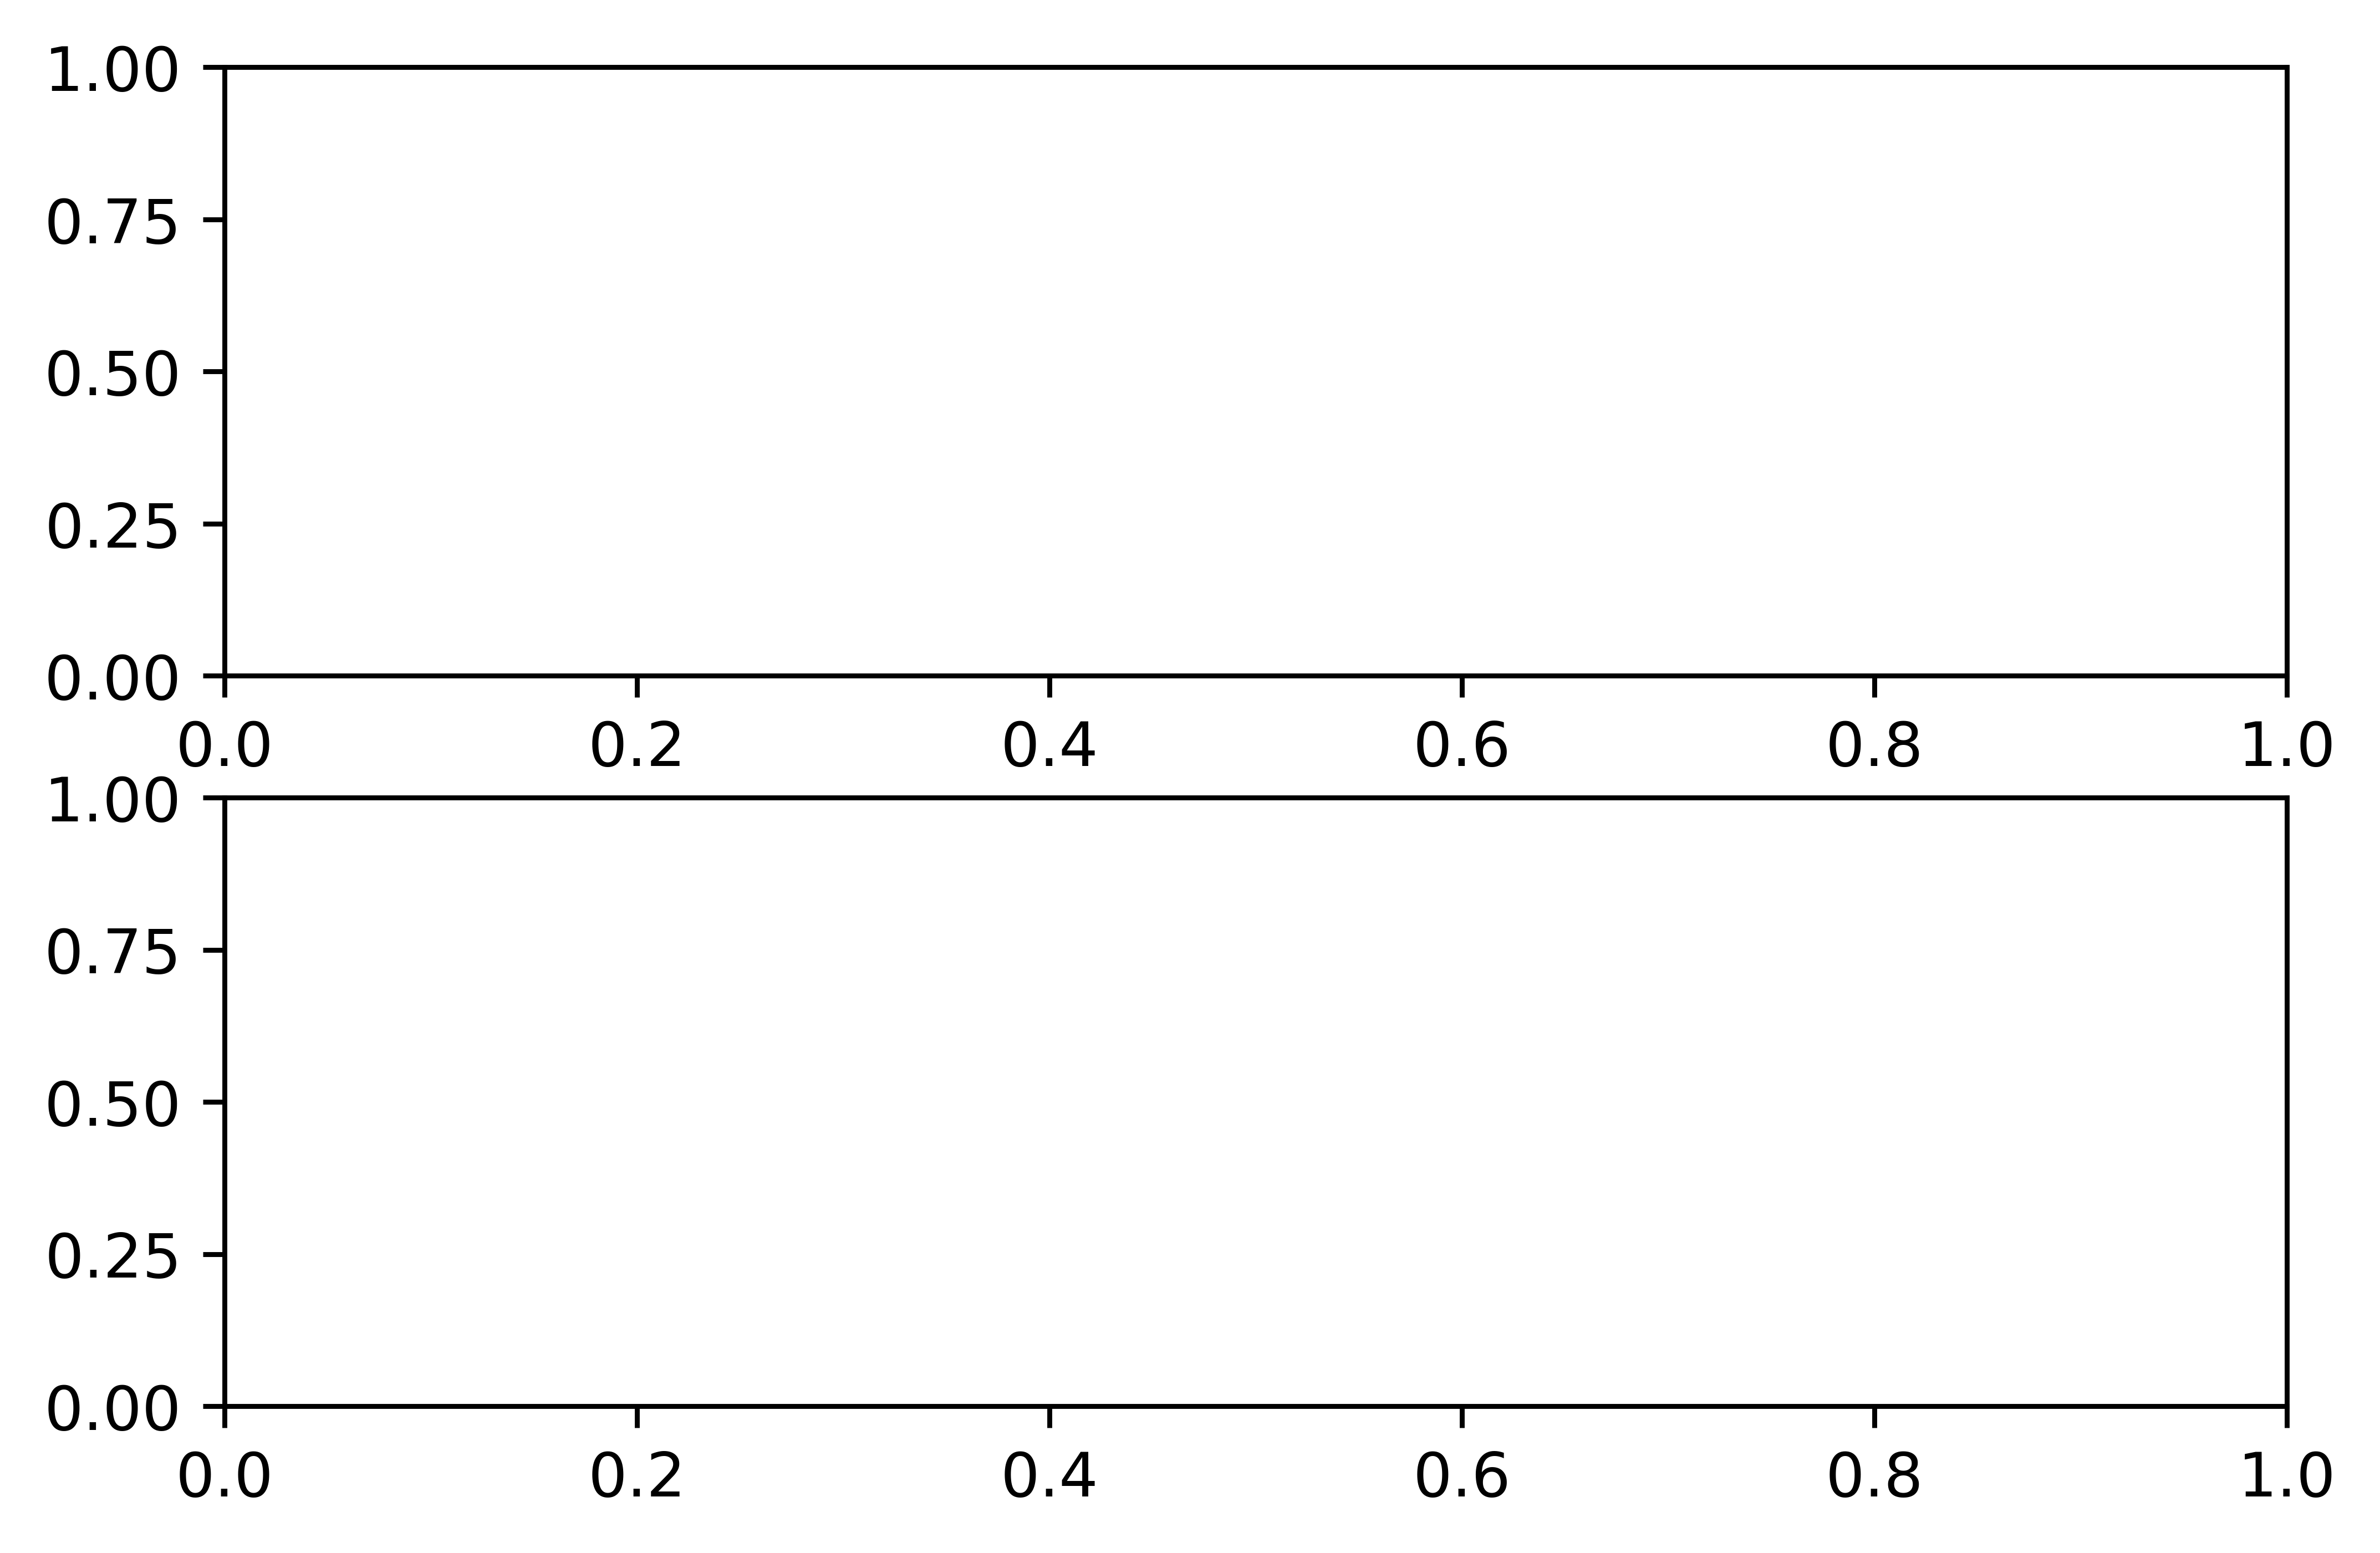

In [3]:
width = 6
fig = plt.figure(dpi=800)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.pcolormesh(lon, lat, u, cmap='RdBu', vmin=-1.25, vmax=1.25)
ax2.pcolormesh(lon, lat, v, cmap='RdBu', vmin=-1.25, vmax=1.25)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# get the file and put it in the right folder
shape_folder = os.path.expanduser('~/Documents/data/boundaries/oceans/')
shape = shapefile.Reader(shape_folder + 'HRmLOS_1.1.shp')

for value in range(0, shape.numRecords):
    feature = shape.shapeRecord(value)
    #print(str(value) + " " + feature.record[0])
    parts = feature.shape.parts
    pts = feature.shape.points
    pts = np.array(pts)

    # keep only the largest parts except for the South/North Pacific Ocean
    # where we have the keep the 2 largest because it is splitted in two
    if feature.record[0] == 'South Pacific Ocean' or feature.record[0] == 'North Pacific Ocean':
        large_parts = np.argpartition(np.diff(feature.shape.parts), -2)[-2:]
    else:
        large_parts = [np.argmax(np.diff(feature.shape.parts))]

    for i in large_parts:
        prange = np.arange(parts[i], parts[i+1]-1)
        ax1.plot(pts[prange,0], pts[prange,1], 'k', linewidth=0.25)
        ax2.plot(pts[prange,0], pts[prange,1], 'k', linewidth=0.25)

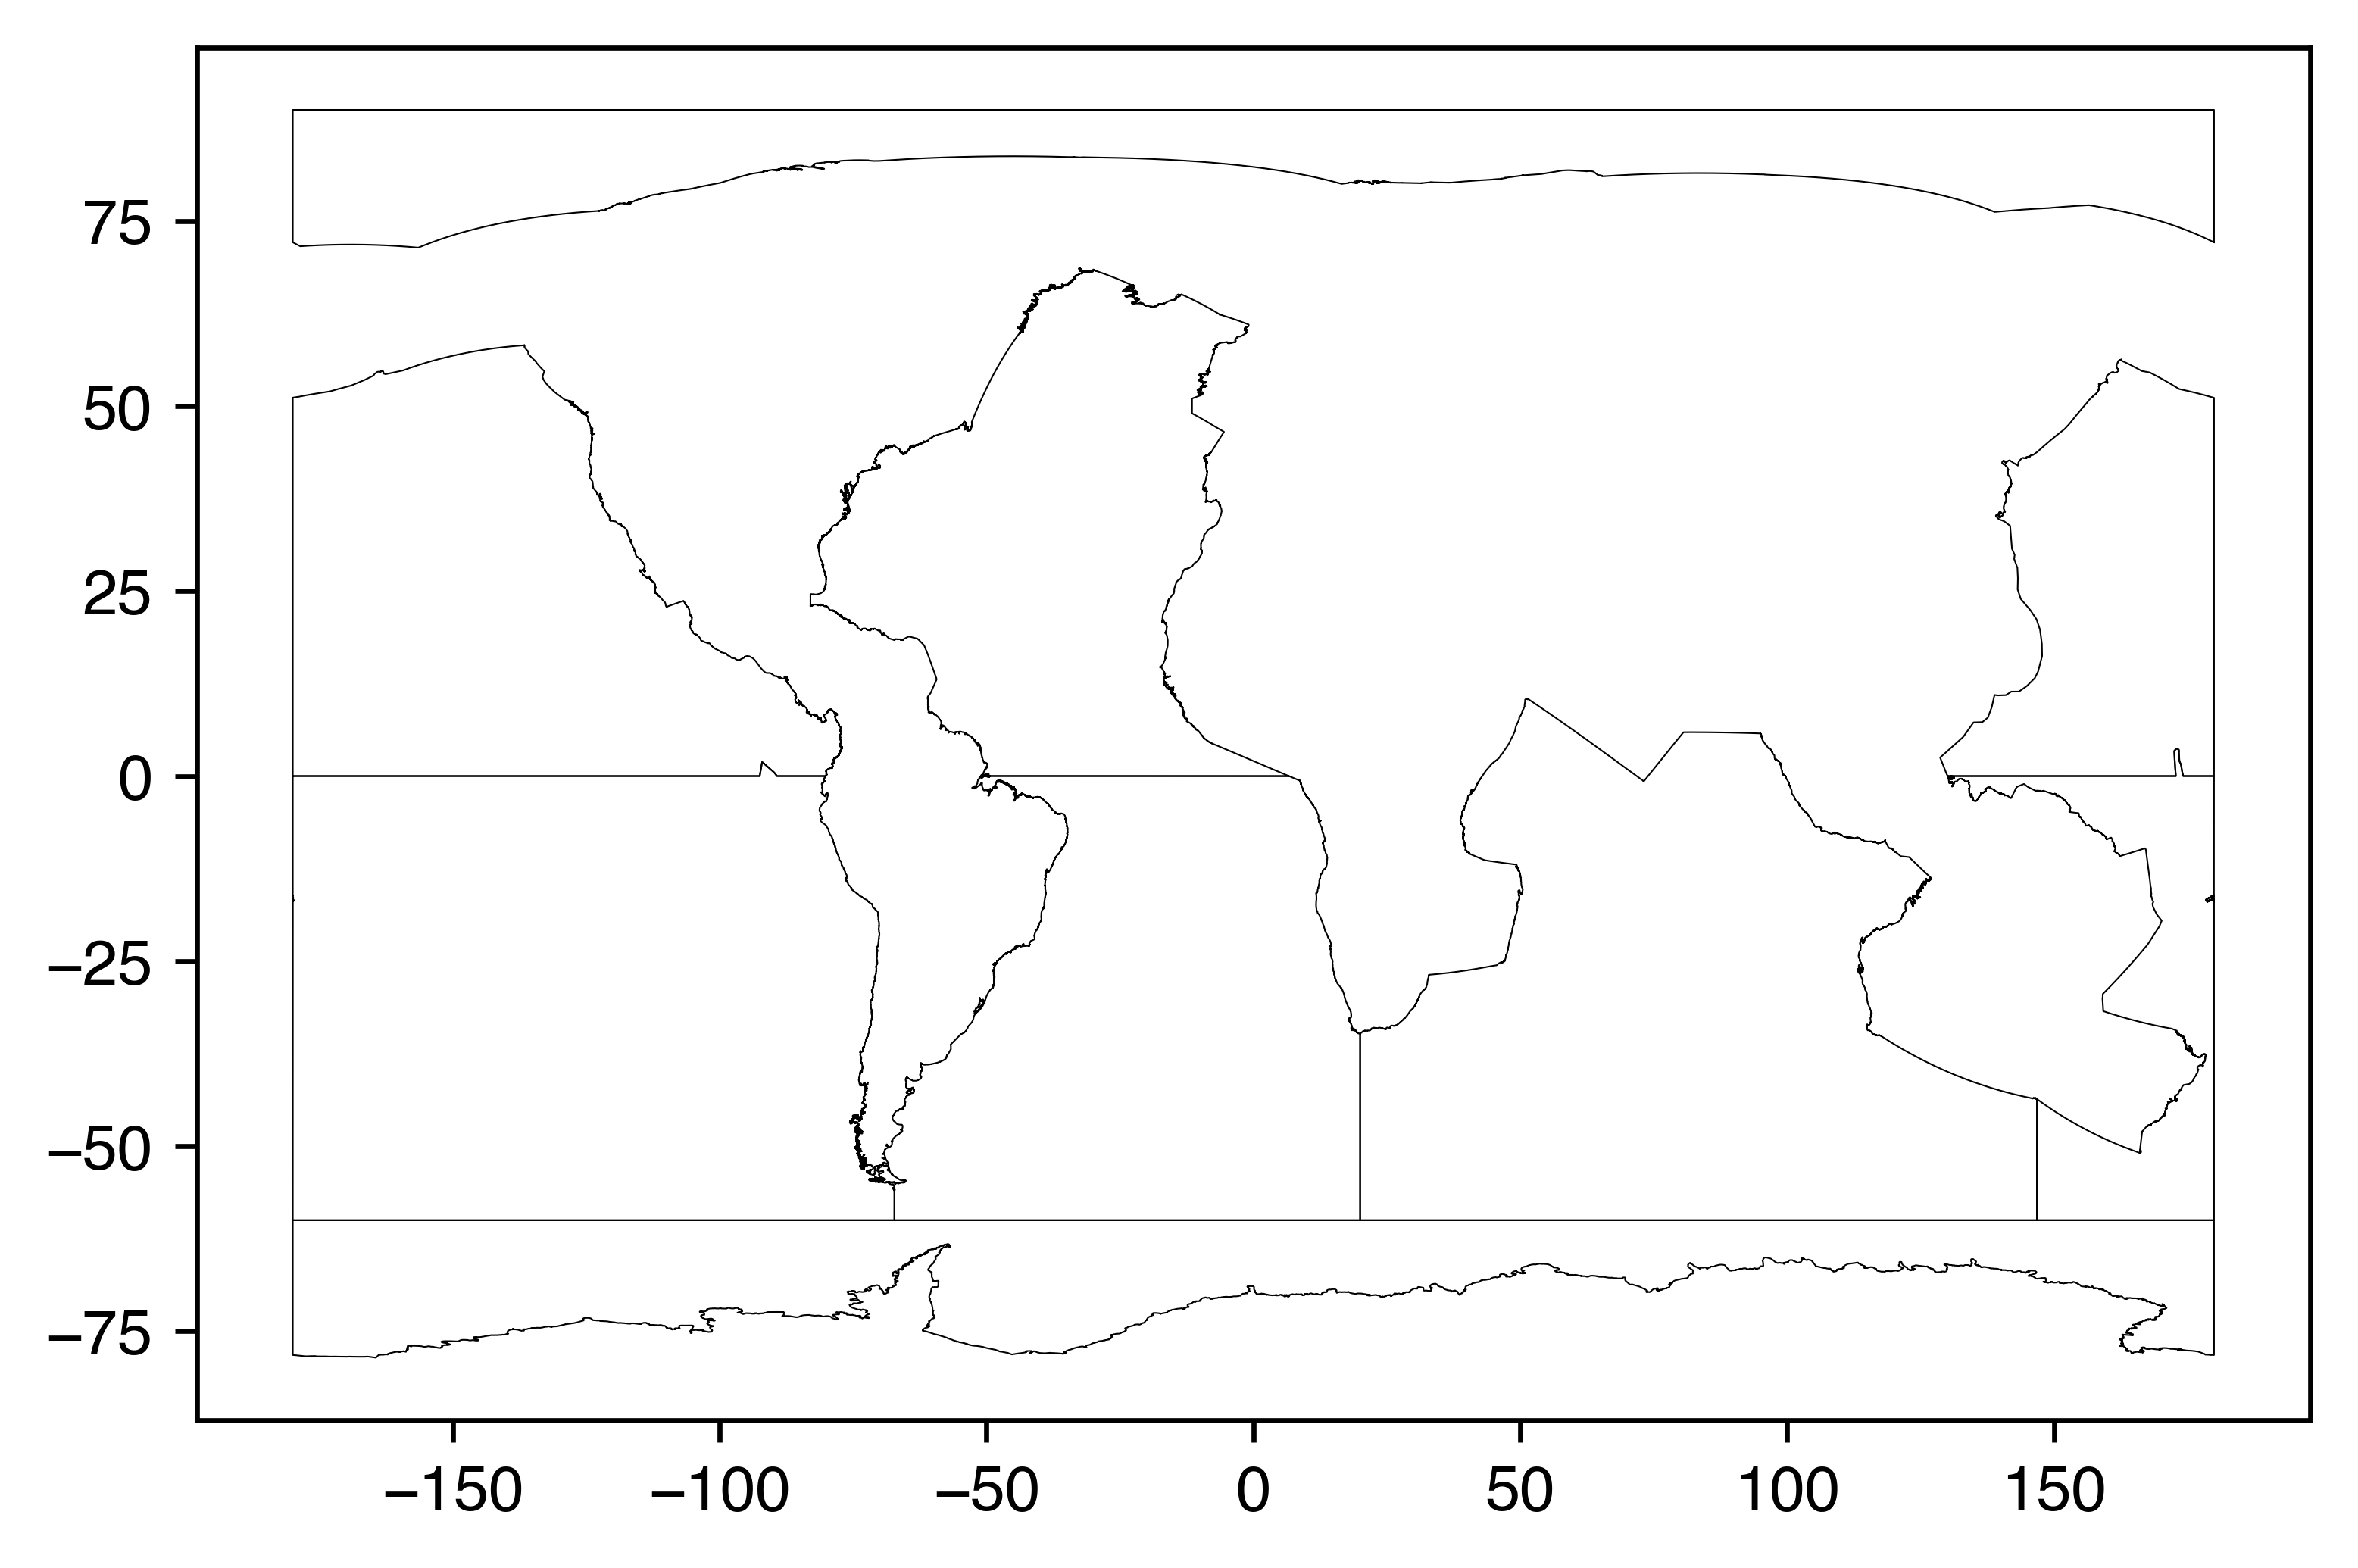

In [11]:
# plot of just the ocean boundaries
shape_folder = os.path.expanduser('~/Documents/data/boundaries/oceans/')
shape = shapefile.Reader(shape_folder + 'HRmLOS_1.1.shp')

width = 6
fig = plt.figure(dpi=600)
ax1 = fig.add_subplot(1, 1, 1)

# plot only selected oceans boundaries
d = {'Indian Ocean': 29, 'South Atlantic Ocean':24, 'North Atlantic Ocean':93, 
              'South Pacific Ocean':22, 'North Pacific Ocean':73, 'Southern Ocean':0, 'Arctic Ocean':104}
for key, value in d.items():
    feature = shape.shapeRecord(value)
    parts = feature.shape.parts
    pts = feature.shape.points
    pts = np.array(pts)

    # keep only the largest parts except for the South/North Pacific Ocean
    # where we have the keep the 2 largest because it is splitted in two (at the +-180°)
    if feature.record[0] == 'South Pacific Ocean' or feature.record[0] == 'North Pacific Ocean':
        large_parts = np.argpartition(np.diff(feature.shape.parts), -2)[-2:]
    else:
        large_parts = [np.argmax(np.diff(feature.shape.parts))]

    for i in large_parts:
        prange = np.arange(parts[i], parts[i+1]-1)
        ax1.plot(pts[prange,0], pts[prange,1], 'k', linewidth=0.25)

# Function that combine multiple regions (ocean and seas) and color them into bassins

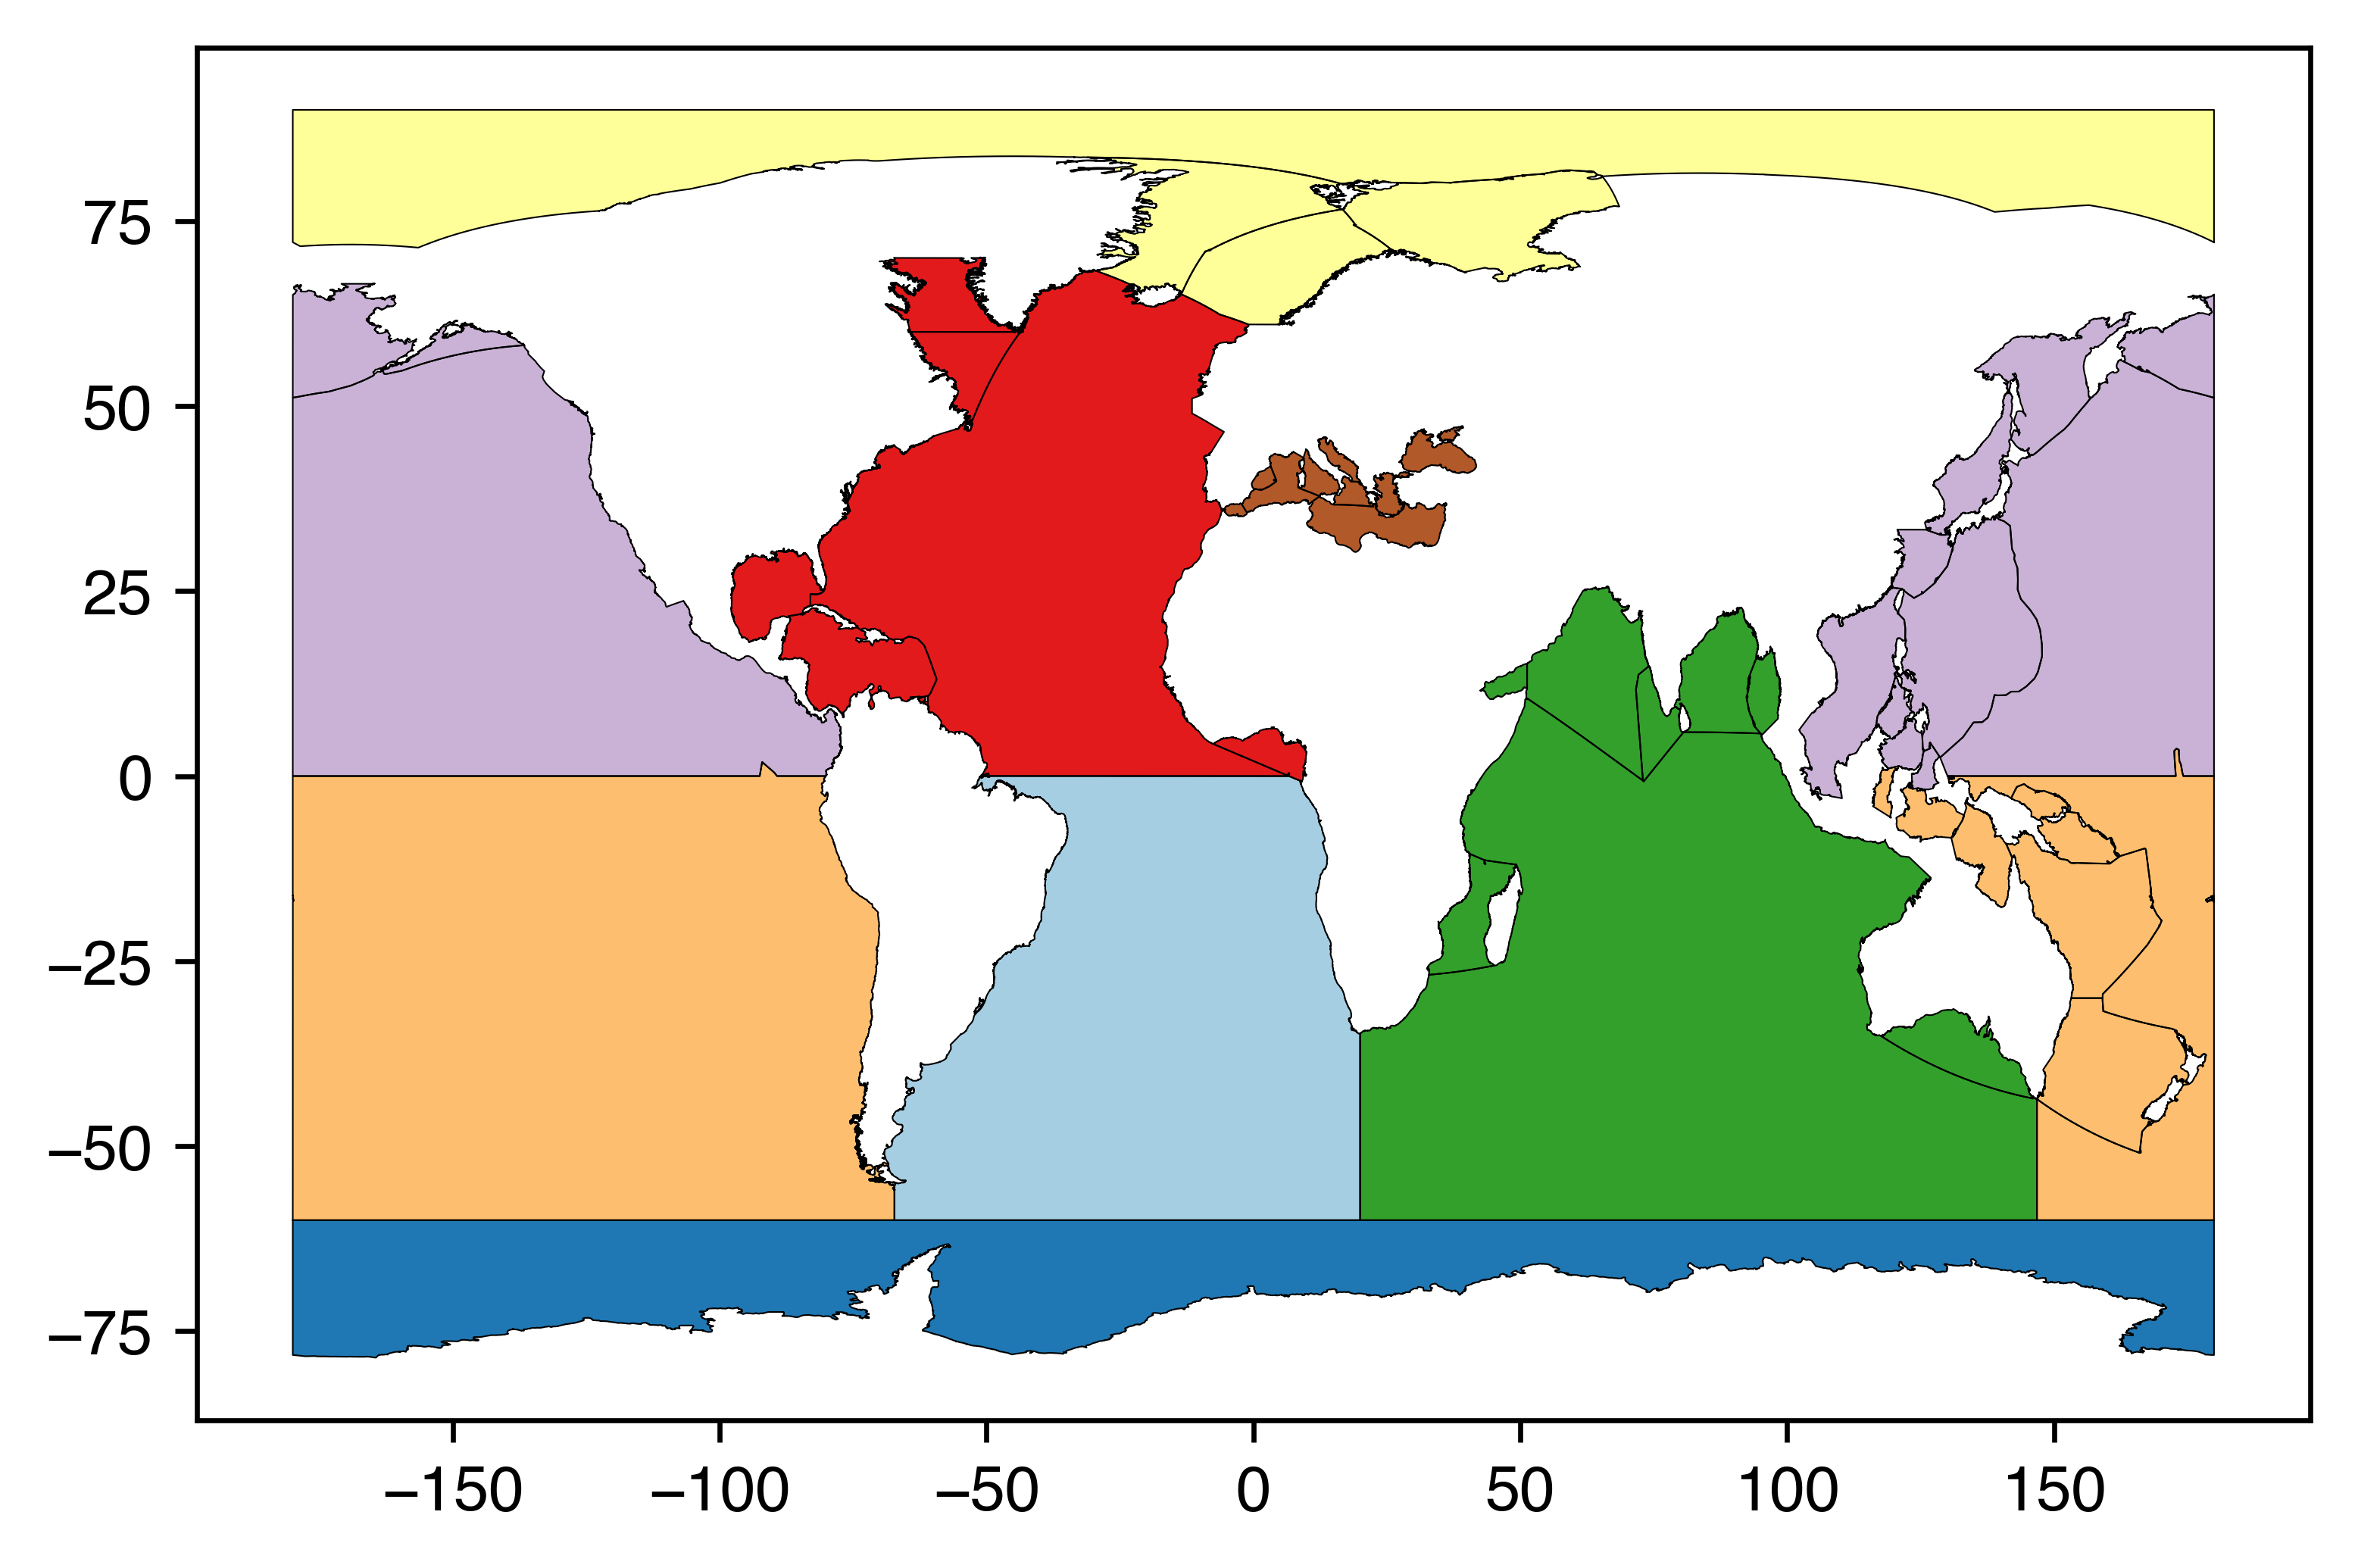

In [27]:
regions_dict = {'South Atlantic Ocean': [24],
                'Southern Ocean': [0],
                # 4 Great Australian Bight
                # 59 Arabian Sea
                # 31 Laccadive Sea
                # 70 Bay of Bengal
                # 32 Andaman Sea
                # 7 Mozambique Channel
                # 35 Gulf of Aden
                'Indian Ocean': [29, 4, 59, 31, 70, 32, 7, 35],

                # 33 Caribbean Sea
                # 51 Gulf of Mexico
                # 78 Labrador Sea
                # 91 Davis Strait
                # 34 Gulf of Guinea
                'North Atlantic Ocean': [93, 33, 51, 78, 91, 34],

                # 3 Tasman Sea
                # 9 Coral Sea
                # 11 Solomon Sea
                # 15 Bismarck Sea
                # 12 Arafura Sea
                # 16 Banda Sea
                # 20 Makassar Strait
                'South Pacific Ocean': [22, 3, 9, 11, 15, 12, 16, 20],

                # 43 Philippine Sea
                # 26 Celebes Sea
                # 30 Sulu Sea
                # 41 Eastern China Sea
                # 47 South China Sea
                # 25 Molukka Sea
                # 77 Japan Sea
                # 86 Sea of Okhotsk
                # 89 Bering Sea
                # 85 Gulf of Alaska
                'North Pacific Ocean': [73, 43, 26, 30, 41, 47, 25, 77, 86, 89, 85],

                # 95 Norwegian Sea
                # 102 Greenland Sea
                # 99 Barentsz Sea
                'Arctic Ocean': [104, 95, 102, 99],

                # 48/55 east/west bassin,
                # 44 Strait of Gibraltar
                # 45 Alboran Sea
                # 52 Balearic
                # 53 Tyrrhenian Sea
                # 49 Ionian Sea
                # 60 Adriatic Sea
                # 56 Aegean Sea
                # 50 Sea of Marmara
                # 67 Black Sea
                # 68 Sea of Azov
                'Mediterranean Sea': [48, 55, 44, 45, 52, 53, 49, 60, 56, 50, 67, 68]}

# read shapefile
shape_folder = os.path.expanduser('~/Documents/data/boundaries/oceans/')
shape = shapefile.Reader(shape_folder + 'HRmLOS_1.1.shp')

width = 6
fig = plt.figure(dpi=600)
ax = fig.add_subplot(1, 1, 1)

# plot region define by the dictionnary
region_id = 1
patches = []
colors = []
for key, values in regions_dict.items():
    for value in values:
        feature = shape.shapeRecord(value)
        parts = feature.shape.parts
        pts = feature.shape.points
        pts = np.array(pts)

        # keep only the largest parts except for the South/North Pacific Ocean
        # where we have the keep the 2 largest because it is splitted in two (at the +-180°)
        if feature.record[0] == 'South Pacific Ocean' or feature.record[0] == 'North Pacific Ocean' or feature.record[0] == 'Bering Sea':
            large_parts = np.argpartition(np.diff(feature.shape.parts), -2)[-2:]
        else:
            large_parts = [np.argmax(np.diff(feature.shape.parts))]

        for i in large_parts:
            prange = np.arange(parts[i], parts[i+1]-1)
            ax.plot(pts[prange,0], pts[prange,1], 'k', linewidth=0.25)
            patches.append(Polygon(pts[prange, :], True))
            colors.append(region_id)
    region_id += 1

p = PatchCollection(patches, cmap=cm.Paired, alpha=1.0)
p.set_array(np.array(colors))  # count / sum(count) for normalization
ax.add_collection(p)